# LIBRARIES

In [ ]:
!pip install lime

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
pip install rdkit

In [ ]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import compose, feature_selection, preprocessing, svm, model_selection, pipeline, metrics
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from xgboost import DMatrix,train

from sklearn.ensemble import RandomForestClassifier

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, AllChem, Draw, DataStructs

import lime
import lime.lime_tabular

from google.colab import files

import pickle

# LOAD AND PROCESS DATA

In [ ]:
BASE_PATH = '/content/drive/MyDrive/reaction proj/data/reaction'
reac = 'reaction'

In [ ]:
# #CONCATENATE DATA
reactions = ['Alkene', 'Baylis', 'heck','suzuki2','suzuki','alcohol1','amide1','ester1','grignard','buchwald']
all_data = pd.DataFrame()

for reac in reactions:
    df = pd.read_excel(f'{BASE_PATH}/{reac}.xlsx')
    df['Reaction Class'] = reac

    print(reac)
    print('Count',df['Reaction'].count())

    df = df.dropna(subset=['Reaction','Reaction ID'])

    df=df.drop_duplicates(subset=['Reaction ID'])
    print('Removed Duplicates based on Reaction ID')
    print('New count',df['Reaction'].count())

    print('Removed Duplicates based on Reaction')
    df=df.drop_duplicates(subset=['Reaction'])
    print('New count',df['Reaction'].count())

    df_cleaned = df[['Reaction ID', 'Reaction', 'Reaction Class']]

    all_data = pd.concat([all_data, df_cleaned], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Alkene
Count 7758
Removed Duplicates based on Reaction ID
New count 3965
Removed Duplicates based on Reaction
New count 3963


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Baylis
Count 10182
Removed Duplicates based on Reaction ID
New count 3992
Removed Duplicates based on Reaction
New count 3989


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


heck
Count 20228
Removed Duplicates based on Reaction ID
New count 3954
Removed Duplicates based on Reaction
New count 3945


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


suzuki2
Count 26970
Removed Duplicates based on Reaction ID
New count 3951
Removed Duplicates based on Reaction
New count 3951


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


suzuki
Count 44871
Removed Duplicates based on Reaction ID
New count 1948
Removed Duplicates based on Reaction
New count 1948


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


alcohol1
Count 16506
Removed Duplicates based on Reaction ID
New count 4986
Removed Duplicates based on Reaction
New count 4967


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


amide1
Count 11362
Removed Duplicates based on Reaction ID
New count 4988
Removed Duplicates based on Reaction
New count 4981


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


ester1
Count 7885
Removed Duplicates based on Reaction ID
New count 4998
Removed Duplicates based on Reaction
New count 4984


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


grignard
Count 2345
Removed Duplicates based on Reaction ID
New count 1080
Removed Duplicates based on Reaction
New count 1080


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


buchwald
Count 625
Removed Duplicates based on Reaction ID
New count 401
Removed Duplicates based on Reaction
New count 400


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a mapping to unify the classes
class_mapping = {
    'suzuki': 'suzuki',
    'suzuki2': 'suzuki',
    # 'heck3': 'heck',# Map both 'suzuki' and 'suzuki2' to 'suzuki'
}

# Update the Reaction Class based on the mapping
all_data['Reaction Class'] = all_data['Reaction Class'].replace(class_mapping)

# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit and transform the Reaction Class column to encode it
all_data['Encoded Class'] = label_encoder.fit_transform(all_data['Reaction Class'])

In [ ]:
# Print counts of each reaction class
reaction_class_counts = all_data['Reaction Class'].value_counts()
print("\nReaction Class Counts:")
print(reaction_class_counts)


Reaction Class Counts:
Reaction Class
suzuki      5899
ester1      4984
amide1      4981
alcohol1    4967
Baylis      3989
Alkene      3963
heck        3945
grignard    1080
buchwald     400
Name: count, dtype: int64


In [ ]:
unique_classes = pd.DataFrame({
    'Reaction Class': label_encoder.classes_,
    'Encoded Class': range(len(label_encoder.classes_))
})

# Print the Reaction Class and Corresponding Encoding
print("\nReaction Class and Corresponding Encoding:")
print(unique_classes)


Reaction Class and Corresponding Encoding:
  Reaction Class  Encoded Class
0         Alkene              0
1         Baylis              1
2       alcohol1              2
3         amide1              3
4       buchwald              4
5         ester1              5
6       grignard              6
7           heck              7
8         suzuki              8


In [ ]:
#DUPLICATE REACTIONS BASED ON REACTIONID
print('Count : ',all_data['Reaction'].count())
all_data = all_data.drop_duplicates(subset=['Reaction ID'])
print('Duplicates Removed! New count :',all_data['Reaction'].count())

Count :  34208
Duplicates Removed! New count : 33989


In [ ]:
#DUPLICATE REACTIONS BASED ON REACTION
print('Count : ',all_data['Reaction'].count())
all_data = all_data.drop_duplicates(subset=['Reaction'])
print('Removed! New count :',all_data['Reaction'].count())
print(all_data['Reaction Class'].value_counts())

Count :  33989
Removed! New count : 33989
Reaction Class
suzuki      5683
ester1      4984
amide1      4979
alcohol1    4967
Baylis      3989
Alkene      3963
heck        3944
grignard    1080
buchwald     400
Name: count, dtype: int64


In [ ]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

#Smile string to ECFP
# Function to use MorganGenerator
def smiles_to_ecfp(smiles, radius=3, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:  # Check if RDKit could parse the SMILES
            return np.zeros((nBits,), dtype=int)

        # Use the newer MorganGenerator
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)

        # Convert the ECFP to a numpy array directly
        array = np.zeros((nBits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(ecfp, array)
        return array

    except Exception as e:
        print(f"Error processing SMILES: {smiles}, Error: {e}")
        return np.zeros((nBits,), dtype=int)

# Function to process a reaction SMILES into ECFP by considering reactants and products separately
def reaction_to_ecfps(reaction_smiles, radius=3, nBits=2048):
    try:
        reactants, products = reaction_smiles.split(">>")
        reactants_ecfp = smiles_to_ecfp(reactants, radius, nBits)
        products_ecfp = smiles_to_ecfp(products, radius, nBits)

        # Combine the reactants and products ECFPs
        combined_ecfp = np.concatenate([reactants_ecfp, products_ecfp])
        return combined_ecfp

    except Exception as e:
        print(f"Error processing reaction: {reaction_smiles}, Error: {e}")
        # Return an array of zeros if there's an issue processing the reaction
        return np.zeros((2 * nBits,), dtype=int)


# Apply the function to convert reaction SMILES to ECFP fingerprints
all_data['Reaction_Fingerprint'] = all_data['Reaction'].apply(lambda x: reaction_to_ecfps(x))

# Check for rows where the fingerprint generation failed (e.g., invalid SMILES)
invalid_rows = all_data[all_data['Reaction_Fingerprint'].isnull()]

Streaming output truncated to the last 5000 lines.
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:22:24] DEPRECATION WARNING: please use MorganGenerator
[14:2

In [ ]:
all_data.to_pickle(f'{BASE_PATH}/Full_reactions_data.pkl')

In [ ]:
all_data = pd.read_pickle(f'{BASE_PATH}/Full_reactions_data.pkl')

In [ ]:
X = np.array(all_data['Reaction_Fingerprint'].tolist())
y = all_data['Encoded Class']

In [ ]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# TUNING AND MODELLING

In [ ]:
best_accuracy = 0
best_params = {}
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.1, 1, 10]
kernel_types = ['linear', 'rbf']

for C in C_values:
    for gamma in gamma_values:
        for kernel in kernel_types:
            # Initialize SVM model
            model = svm.SVC(C=C, kernel=kernel, gamma=gamma)
            model.fit(X_train, y_train)  # Train on the training set

            # Validate the model
            y_val_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)
            print(f'Validation Accuracy for C={C}, Gamma={gamma}, Kernel={kernel}: {accuracy:.4f}')

            # Update best parameters if accuracy is improved
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}

print(f'Best Parameters: {best_params}, Best Validation Accuracy: {best_accuracy:.4f}')

Validation Accuracy for C=0.1, Gamma=0.01, Kernel=linear: 0.9897
Validation Accuracy for C=0.1, Gamma=0.01, Kernel=rbf: 0.9179
Validation Accuracy for C=0.1, Gamma=0.1, Kernel=linear: 0.9897
Validation Accuracy for C=0.1, Gamma=0.1, Kernel=rbf: 0.1653
Validation Accuracy for C=0.1, Gamma=1, Kernel=linear: 0.9897


In [ ]:
from sklearn.metrics import accuracy_score

final_model = svm.SVC(C=0.1, gamma=0.01, kernel='linear', probability=True)
final_model.fit(X_train, y_train)  # Train on the full training set

SVC(C=0.1, gamma=0.01, kernel='linear', probability=True)

In [ ]:
# Save the trained model using joblib
joblib.dump(final_model, f'{BASE_PATH}/final_model_svc.pkl')
print("Model saved successfully!")

Model saved successfully!


# RESULT ANALYSIS

In [ ]:
# Load the trained model
final_model = joblib.load(f'{BASE_PATH}/final_model_svc.pkl')
print("Model loaded successfully!")

# Predict on the val set
y_val_pred = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'val Accuracy: {val_accuracy:.4f}')

# Predict on the test set
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Model loaded successfully!
val Accuracy: 0.9897
Test Accuracy: 0.9919


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

# 1. Performance of each class: Precision, Recall (Sensitivity), F1-Score
print("Classification Report on Validation Set:")
print(classification_report(y_test, y_test_pred))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       784
           1       0.99      1.00      1.00       797
           2       1.00      1.00      1.00       998
           3       1.00      1.00      1.00       989
           4       0.99      0.91      0.95        86
           5       0.99      1.00      1.00       995
           6       1.00      1.00      1.00       221
           7       0.97      0.98      0.97       776
           8       0.99      0.99      0.99      1152

    accuracy                           0.99      6798
   macro avg       0.99      0.98      0.99      6798
weighted avg       0.99      0.99      0.99      6798



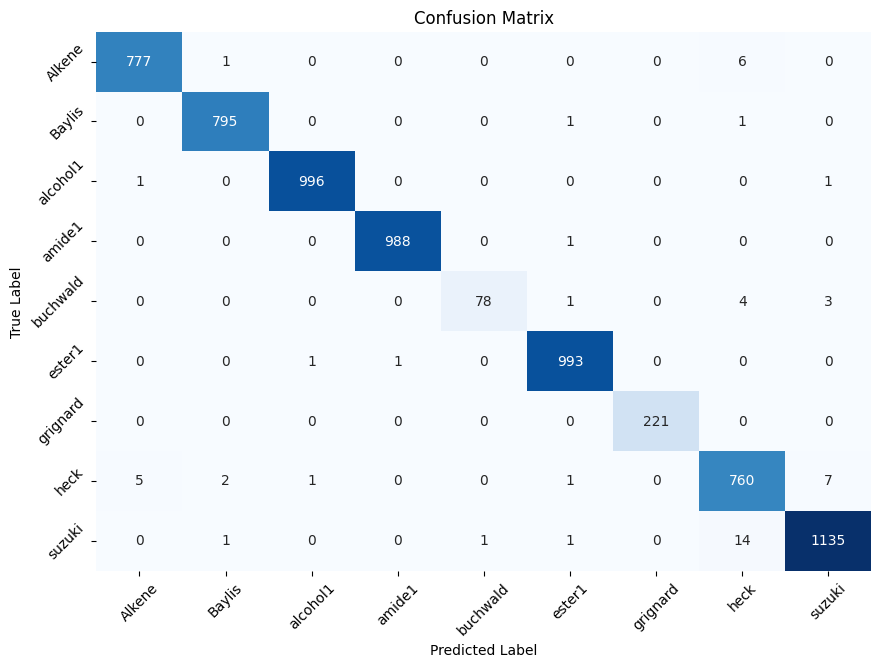

In [ ]:
# Reaction Class names from label_encoder
reaction_classes = label_encoder.classes_

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=reaction_classes, columns=reaction_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
t_df = pd.read_csv('/content/drive/MyDrive/reaction proj/data/random_split_9.tsv', sep='\t')
t_df['Reaction Class'] = 8

t_df['RF'] = t_df['rxn'].apply(lambda x: reaction_to_ecfps(x))


yt_1 = t_df['Reaction Class'].values
Xt_1 = list(t_df['RF'])

# Predict on the test set
y_pred1 = final_model.predict(Xt_1)

# Calculate the accuracy on the test set
accuracy1 = accuracy_score(yt_1, y_pred1)
print("Test set accuracy:", accuracy1)

Streaming output truncated to the last 5000 lines.
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:01:15] DEPRECATION WARNING: please use MorganGenerator
[12:0

Test set accuracy: 0.9715277777777778


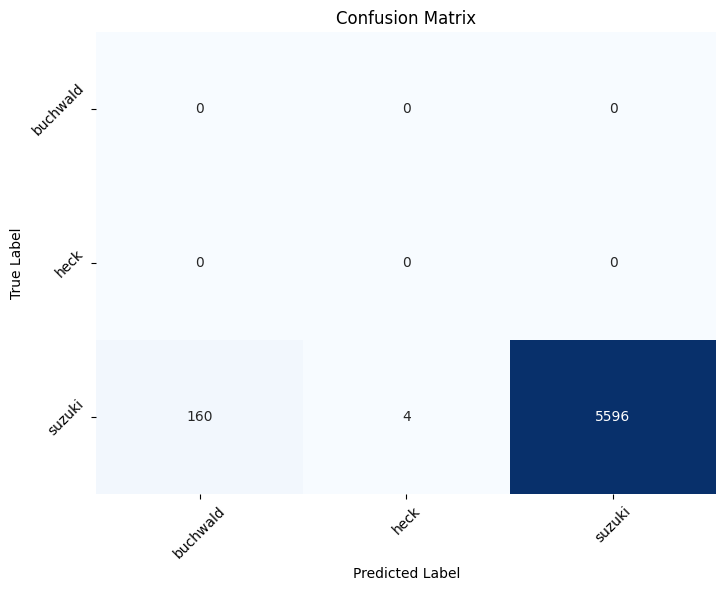

In [ ]:
conf_matrix_git = confusion_matrix(yt_1, y_pred1)

uni = np.unique(y_pred1)
reaction_classes_g = [reaction_classes[i] for i in uni]

conf_matrix_dfg = pd.DataFrame(conf_matrix_git, index=reaction_classes_g, columns=reaction_classes_g)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dfg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
# Identify wrongly predicted indices
wrongly_predicted_indices = {}
for index, (true_class, predicted_class) in enumerate(zip(yt_1, y_pred1)):
    if true_class != predicted_class:
        if true_class not in wrongly_predicted_indices:
            wrongly_predicted_indices[true_class] = []  # Create a list for the true class
        wrongly_predicted_indices[true_class].append((index, predicted_class))

# Display the indices of wrongly predicted classes along with predicted classes
for true_class, predictions in wrongly_predicted_indices.items():
    print(predictions)
    print(f"True class {true_class} wrongly predicted as class(es):")
    for index, predicted_class in predictions:
        print(f"Index: {index}, Predicted Class: {predicted_class}")

[(76, 4), (85, 4), (95, 4), (96, 4), (158, 4), (219, 4), (234, 4), (282, 4), (294, 4), (312, 4), (317, 4), (318, 4), (356, 4), (388, 4), (395, 4), (404, 4), (429, 4), (432, 4), (532, 4), (537, 4), (568, 4), (569, 4), (601, 4), (613, 4), (620, 4), (631, 4), (637, 4), (709, 4), (788, 7), (791, 4), (850, 4), (852, 4), (915, 4), (977, 4), (999, 4), (1128, 4), (1195, 4), (1242, 4), (1249, 4), (1295, 4), (1392, 4), (1441, 4), (1486, 4), (1516, 4), (1523, 4), (1529, 4), (1533, 4), (1535, 4), (1580, 4), (1648, 4), (1802, 4), (1814, 4), (1858, 7), (1877, 4), (1919, 4), (1995, 4), (2046, 4), (2210, 4), (2242, 4), (2259, 4), (2344, 4), (2358, 4), (2402, 4), (2424, 4), (2437, 4), (2452, 4), (2458, 4), (2489, 4), (2507, 4), (2522, 4), (2530, 4), (2556, 4), (2576, 4), (2632, 4), (2685, 4), (2748, 4), (2750, 4), (2757, 4), (2843, 4), (2928, 4), (3055, 4), (3097, 4), (3191, 4), (3337, 4), (3366, 4), (3369, 4), (3383, 4), (3404, 4), (3422, 4), (3476, 4), (3527, 4), (3610, 4), (3628, 4), (3650, 4), (366

# LIME EXPLANATION

In [ ]:
all_data[all_data['Encoded Class']==6]

,Reaction ID,Reaction,Reaction Class,Encoded Class,Reaction_Fingerprint
32728,25959640,BrC1=CC=CC=C1.OC1=C(C=O)C=CC=C1>>OC(C1=CC=CC=C...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32729,28601472,CC1=CC=C(Br)C=C1.OC1=C(C=O)C=CC=C1>>CC1=CC=C(C...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32730,694268,BrCC=C.CC(=O)C1=CC=CC=C1>>CC(O)(CC=C)C1=CC=CC=C1,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32731,3530275,CCCCCCC=O.ClCC=C>>CCCCCCC(O)CC=C,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32732,4246161,O=C1C2=CC=CN=C2C2=C1C=CC=N2.BrC1=CC=CC=C1C1=CC...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
33803,44261537,CN1C=C(C2=CC=C(Cl)C=C12)C1=C(C(=O)N(C)C1=O)C1=...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
33804,44261542,ClC1=CC=C(C=C1)C1=C(C(=O)OC1=O)C1=CNC2=CC(Cl)=...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
33805,44261545,ClC1=CC=C(CC2=C(C(=O)OC2=O)C2=CNC3=CC(Cl)=CC=C...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
33806,44261548,ClC1=CC=C(CC2=C(C(=O)OC2=O)C2=CNC3=CC(Cl)=CC=C...,grignard,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Initialize explainer
explainer = lime.lime_tabular.LimeTabularExplainer(np.asarray(X_train), verbose=True, mode='classification')

In [ ]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
import dill

# Save using dill
with open('lime_explainer.dill', 'wb') as f:
    dill.dump(explainer, f)

# Load using dill
with open('lime_explainer.dill', 'rb') as f:
    explainer = dill.load(f)

In [ ]:
# Select a reaction for explanation
i = 32729
target_fp =all_data['Reaction_Fingerprint'][i] # ECFP vector

target_reaction = all_data.iloc[i]['Reaction'] # SMILES string

target_reaction

'O=C1CCC1.ClC1=CC=C(I)C=C1>>OC1(CCC1)C1=CC=C(Cl)C=C1'

In [ ]:
# 0: 'Alkene', 1: 'Baylis', 2: 'heck', 3: 'suzuki2'
pred = final_model.predict([target_fp])[0]
truth = all_data['Encoded Class'][i]
print(f'Prediction: {pred} Truth: {truth}')

Prediction: 6 Truth: 6


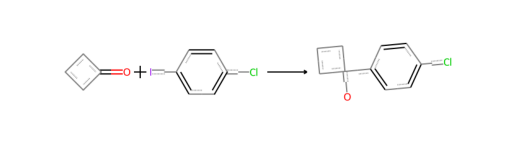

In [ ]:
def visualise_reaction(target_reaction):
  # Convert the SMILES string to an RDKit reaction object
  reaction = Chem.rdChemReactions.ReactionFromSmarts(target_reaction)

  # Draw the reaction and save as an image
  img = Draw.ReactionToImage(reaction)

  plt.imshow(img)
  plt.axis('off')  # Hide the axis
  plt.show()

visualise_reaction(target_reaction)

In [ ]:
# Function to get substructures in SMILES format
def get_substructure_smiles(mol, bit_info, bit):
    substructures = []
    if bit in bit_info:
        for atom_idx, radius in bit_info[bit]:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
            amap = {}
            submol = Chem.PathToSubmol(mol, env, atomMap=amap)
            smiles = Chem.MolToSmiles(submol, canonical=True)
            substructures.append(smiles)
    return substructures

# I think these two functions are the same, Looks like you are generating the correct smiles its just the matching that is messing up.
# It might be easier to use this function then match the smiles as we generate structures (see below)
# returning a dictionary ensures the correct smiles are matched to the correct bits then we can query directly from that
def smiles_from_bitinfo(mol, bit_info):
    bit_smiles = {}
    for bit, info in bit_info.items():
        for atom, rad in info:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom)
            amap = {}
            # this will generate a submol if there are bonds to the atom we are interested in.
            # If there are no bonds (eg/ the bit corresponds to one atom with radius=0) we do not get a smiles
            submol=Chem.PathToSubmol(mol, env, atomMap=amap)
            smi = Chem.MolToSmiles(submol)
            bit_smiles[bit] = smi
    return bit_smiles

In [ ]:
# GET REACTANT AND PRODUCT BIT INFO

# Split the target reaction into reactants and products
reactants, products = target_reaction.split(">>")

# Convert the SMILES representation of the reactants and products into RDKit molecule objects
r_mol = Chem.MolFromSmiles(reactants)
p_mol = Chem.MolFromSmiles(products)

# Dictionaries to store bit information for reactants and products
r_bi = {}
p_bi = {}

# Generate Morgan fingerprints for both reactants and products
# Using radius=3 and nBits=2048
fpr = AllChem.GetMorganFingerprintAsBitVect(r_mol, radius=3, bitInfo=r_bi, nBits=2048)
fpp = AllChem.GetMorganFingerprintAsBitVect(p_mol, radius=3, bitInfo=p_bi, nBits=2048)


[16:51:17] DEPRECATION WARNING: please use MorganGenerator
[16:51:17] DEPRECATION WARNING: please use MorganGenerator


In [ ]:
r_bi

{216: ((6, 1),),
 225: ((1, 1), (9, 3)),
 273: ((7, 3),),
 314: ((0, 1),),
 503: ((9, 2),),
 561: ((5, 1),),
 650: ((0, 0),),
 661: ((10, 0),),
 703: ((6, 3),),
 723: ((1, 2),),
 816: ((7, 2), (12, 2)),
 892: ((3, 2),),
 926: ((2, 0), (3, 0), (4, 0)),
 947: ((10, 1),),
 1028: ((3, 1),),
 1070: ((6, 2),),
 1380: ((1, 0), (6, 0), (9, 0)),
 1494: ((8, 2), (11, 2)),
 1594: ((9, 1),),
 1683: ((5, 0),),
 1738: ((2, 1), (4, 1)),
 1750: ((7, 1), (8, 1), (11, 1), (12, 1)),
 1873: ((7, 0), (8, 0), (11, 0), (12, 0))}

In [ ]:
p_bi

{216: ((8, 1),),
 408: ((1, 2),),
 484: ((6, 2), (11, 2)),
 556: ((5, 1),),
 561: ((9, 1),),
 641: ((7, 3),),
 703: ((8, 3),),
 807: ((0, 0),),
 812: ((6, 3),),
 816: ((7, 2), (10, 2)),
 926: ((2, 0), (3, 0), (4, 0)),
 1028: ((3, 1),),
 1060: ((1, 0),),
 1070: ((8, 2),),
 1107: ((1, 3),),
 1154: ((0, 1),),
 1156: ((1, 1),),
 1162: ((2, 1), (4, 1)),
 1380: ((5, 0), (8, 0)),
 1683: ((9, 0),),
 1717: ((5, 2),),
 1750: ((6, 1), (7, 1), (10, 1), (11, 1)),
 1839: ((5, 3),),
 1873: ((6, 0), (7, 0), (10, 0), (11, 0)),
 1932: ((2, 2),),
 2028: ((3, 2),)}

In [ ]:
# Adjust product bit indices to match the input fingerprint indices
updated_p_bi = {key + 2048: value for key, value in p_bi.items()}
p_onbits = [x + 2048 for x in fpp.GetOnBits()]
r_onbits = [x for x in fpr.GetOnBits()]
updated_p_bi

{2264: ((8, 1),),
 2456: ((1, 2),),
 2532: ((6, 2), (11, 2)),
 2604: ((5, 1),),
 2609: ((9, 1),),
 2689: ((7, 3),),
 2751: ((8, 3),),
 2855: ((0, 0),),
 2860: ((6, 3),),
 2864: ((7, 2), (10, 2)),
 2974: ((2, 0), (3, 0), (4, 0)),
 3076: ((3, 1),),
 3108: ((1, 0),),
 3118: ((8, 2),),
 3155: ((1, 3),),
 3202: ((0, 1),),
 3204: ((1, 1),),
 3210: ((2, 1), (4, 1)),
 3428: ((5, 0), (8, 0)),
 3731: ((9, 0),),
 3765: ((5, 2),),
 3798: ((6, 1), (7, 1), (10, 1), (11, 1)),
 3887: ((5, 3),),
 3921: ((6, 0), (7, 0), (10, 0), (11, 0)),
 3980: ((2, 2),),
 4076: ((3, 2),)}

In [ ]:
# Generate SMILES representations from bit information
reagent_smiles = smiles_from_bitinfo(r_mol, r_bi)
product_smiles = smiles_from_bitinfo(p_mol, updated_p_bi)

# Debug prints for verifying SMILES mappings
print("Reagent SMILES mapping from bit info:", reagent_smiles)  # Mapping for reactants
print("Product SMILES mapping from bit info:", product_smiles)  # Mapping for products


Reagent SMILES mapping from bit info: {216: 'cc(c)Cl', 225: 'Ic1ccccc1', 273: 'Clc1ccc(I)cc1', 314: 'C=O', 503: 'ccc(I)cc', 561: 'cCl', 650: '', 661: '', 703: 'Clc1ccccc1', 723: 'O=C1CCC1', 816: 'cccc(c)Cl', 892: 'C1CCC1', 926: '', 947: 'cI', 1028: 'CCC', 1070: 'ccc(Cl)cc', 1380: '', 1494: 'cccc(c)I', 1594: 'cc(c)I', 1683: '', 1738: 'CCC', 1750: 'ccc', 1873: ''}
Product SMILES mapping from bit info: {2264: 'cc(c)Cl', 2456: 'cc(c)C1(O)CCC1', 2532: 'cccc(c)C', 2604: 'cc(c)C', 2609: 'cCl', 2689: 'Cc1ccc(Cl)cc1', 2751: 'Clc1ccccc1', 2855: '', 2860: 'CC(C)(O)c1ccc(Cl)cc1', 2864: 'cccc(c)Cl', 2974: '', 3076: 'CCC', 3108: '', 3118: 'ccc(Cl)cc', 3155: 'ccc(cc)C1(O)CCC1', 3202: 'CO', 3204: 'CC(c)(C)O', 3210: 'CCC', 3428: '', 3731: '', 3765: 'ccc(cc)C(C)(C)O', 3798: 'ccc', 3887: 'OC1(c2ccccc2)CCC1', 3921: '', 3980: 'cC1(O)CCC1', 4076: 'C1CCC1'}


In [ ]:
# Use LIME to explain the instance
exp = explainer.explain_instance(np.asarray(target_fp), final_model.predict_proba, num_features=len(target_fp))

Intercept 1.1226886748202438
Prediction_local [0.13295168]
Right: 6.910148341326653e-07


In [ ]:
map = exp.as_map()[1]
print('Map of important bits and their scores:', map)

# Retrieve important bits and their corresponding scores from the map
important_bits = [i[0] for i in map]
importance_scores = [i[1] for i in map]

Map of important bits and their scores: [(1004, 0.11629968801796671), (3627, 0.10736968040955298), (3909, -0.08924543588066061), (2917, 0.08918584710955917), (1580, 0.08865610901292016), (2487, -0.08285209703007884), (2544, 0.08196617663032758), (1739, 0.08079634068827443), (891, 0.08066652966013069), (3043, -0.07884267095701228), (4016, 0.07881066833118876), (3070, -0.07828366687743407), (3332, -0.07816734837215113), (1490, -0.07540039109321141), (1256, -0.07436022600808859), (1344, 0.0740392341958029), (1806, -0.07264037992229708), (2222, 0.07251719901676514), (2172, -0.0721461997344757), (174, -0.07203359525281101), (3726, 0.07096777233980293), (3788, -0.07087314603291615), (3388, 0.07069815668846983), (2548, -0.06911280010721234), (2395, 0.06863373080274217), (3173, -0.06781115202902635), (1987, -0.06746603556796983), (2955, -0.06732900193076555), (2708, -0.06702858461402779), (1246, 0.06668885053561567), (166, 0.06654609278698169), (1596, -0.06632293956632727), (2736, -0.065774196

In [ ]:
# Sort the explanation map by importance score
sorted_map = sorted(map, key=lambda tup: tup[1], reverse=True)
print("Sorted map of important bits with scores:", sorted_map)

Sorted map of important bits with scores: [(1004, 0.11629968801796671), (3627, 0.10736968040955298), (2917, 0.08918584710955917), (1580, 0.08865610901292016), (2544, 0.08196617663032758), (1739, 0.08079634068827443), (891, 0.08066652966013069), (4016, 0.07881066833118876), (1344, 0.0740392341958029), (2222, 0.07251719901676514), (3726, 0.07096777233980293), (3388, 0.07069815668846983), (2395, 0.06863373080274217), (1246, 0.06668885053561567), (166, 0.06654609278698169), (4014, 0.06485908564327555), (2498, 0.06454897109639945), (393, 0.06446181570147856), (1725, 0.0644392424629001), (2112, 0.06432082746498702), (3036, 0.0639512145662912), (3723, 0.06312752850525635), (777, 0.06282742482154481), (1288, 0.061028812918201336), (2173, 0.05984824768390838), (3354, 0.059494659746143715), (1193, 0.05829889627067947), (2134, 0.05810929254109586), (2072, 0.05741220612581031), (1546, 0.05706409798922134), (659, 0.05651447850532512), (1016, 0.05637573515715772), (852, 0.05610150343842417), (2941, 

In [ ]:
reagent_smiles

{216: 'cc(c)Cl',
 225: 'Ic1ccccc1',
 273: 'Clc1ccc(I)cc1',
 314: 'C=O',
 503: 'ccc(I)cc',
 561: 'cCl',
 650: '',
 661: '',
 703: 'Clc1ccccc1',
 723: 'O=C1CCC1',
 816: 'cccc(c)Cl',
 892: 'C1CCC1',
 926: '',
 947: 'cI',
 1028: 'CCC',
 1070: 'ccc(Cl)cc',
 1380: '',
 1494: 'cccc(c)I',
 1594: 'cc(c)I',
 1683: '',
 1738: 'CCC',
 1750: 'ccc',
 1873: ''}

In [ ]:
# Initialize lists to store new bit information and legends
new_bit_list2 = []
full_leg2 = []
# Loop through the sorted map to collect bits and their corresponding SMILES
for i in sorted_map:
        bit = i[0]  # The bit number
        importance = i[1]  # Importance score of the bit

        if bit in r_onbits:  # If bit belongs to the reactant
            rsmiles = reagent_smiles[bit]  # Get SMILES from the reactant mapping
            print("Reactant - Bit:", bit, "Importance:", importance, "SMILES:", rsmiles)  # Debug print
            full_leg2.append(f"{round(importance, 3)} | {bit} | {rsmiles}")  # Create legend entry
            new_bit_list2.append((r_mol, bit, r_bi))  # Add to the new bit list

        elif bit in p_onbits:  # If bit belongs to the product
            psmiles = product_smiles[bit]  # Get SMILES from the product mapping
            print("Product - Bit:", bit, "Importance:", importance, "SMILES:", psmiles)  # Debug print
            full_leg2.append(f"{round(importance, 3)} {bit} | {psmiles}")  # Create legend entry
            new_bit_list2.append((p_mol, bit, updated_p_bi))  # Add to the new bit list

# Debug prints for final lists
print("Final new_bit_list2:", new_bit_list2)  # Contains molecules and important bits
print("Final legends (full_leg2):", full_leg2)  # Contains the legends for visualization

Reactant - Bit: 661 Importance: 0.02909602712242045 SMILES: 
Reactant - Bit: 503 Importance: 0.02816251560336231 SMILES: ccc(I)cc
Reactant - Bit: 1750 Importance: 0.024654364445537095 SMILES: ccc
Reactant - Bit: 947 Importance: 0.016792724487664355 SMILES: cI
Reactant - Bit: 1494 Importance: 0.01670345996378867 SMILES: cccc(c)I
Product - Bit: 2855 Importance: 0.016515171473189046 SMILES: 
Product - Bit: 3210 Importance: 0.01643536332660676 SMILES: CCC
Reactant - Bit: 1028 Importance: 0.01605930234660808 SMILES: CCC
Product - Bit: 2532 Importance: 0.015234157961856466 SMILES: cccc(c)C
Reactant - Bit: 1683 Importance: 0.015195687433751747 SMILES: 
Reactant - Bit: 1594 Importance: 0.013144331294809113 SMILES: cc(c)I
Reactant - Bit: 723 Importance: 0.011269730609839396 SMILES: O=C1CCC1
Product - Bit: 2456 Importance: 0.010614953526413836 SMILES: cc(c)C1(O)CCC1
Product - Bit: 3076 Importance: 0.010354534979272642 SMILES: CCC
Reactant - Bit: 225 Importance: 0.009986482971492145 SMILES: Ic1cc

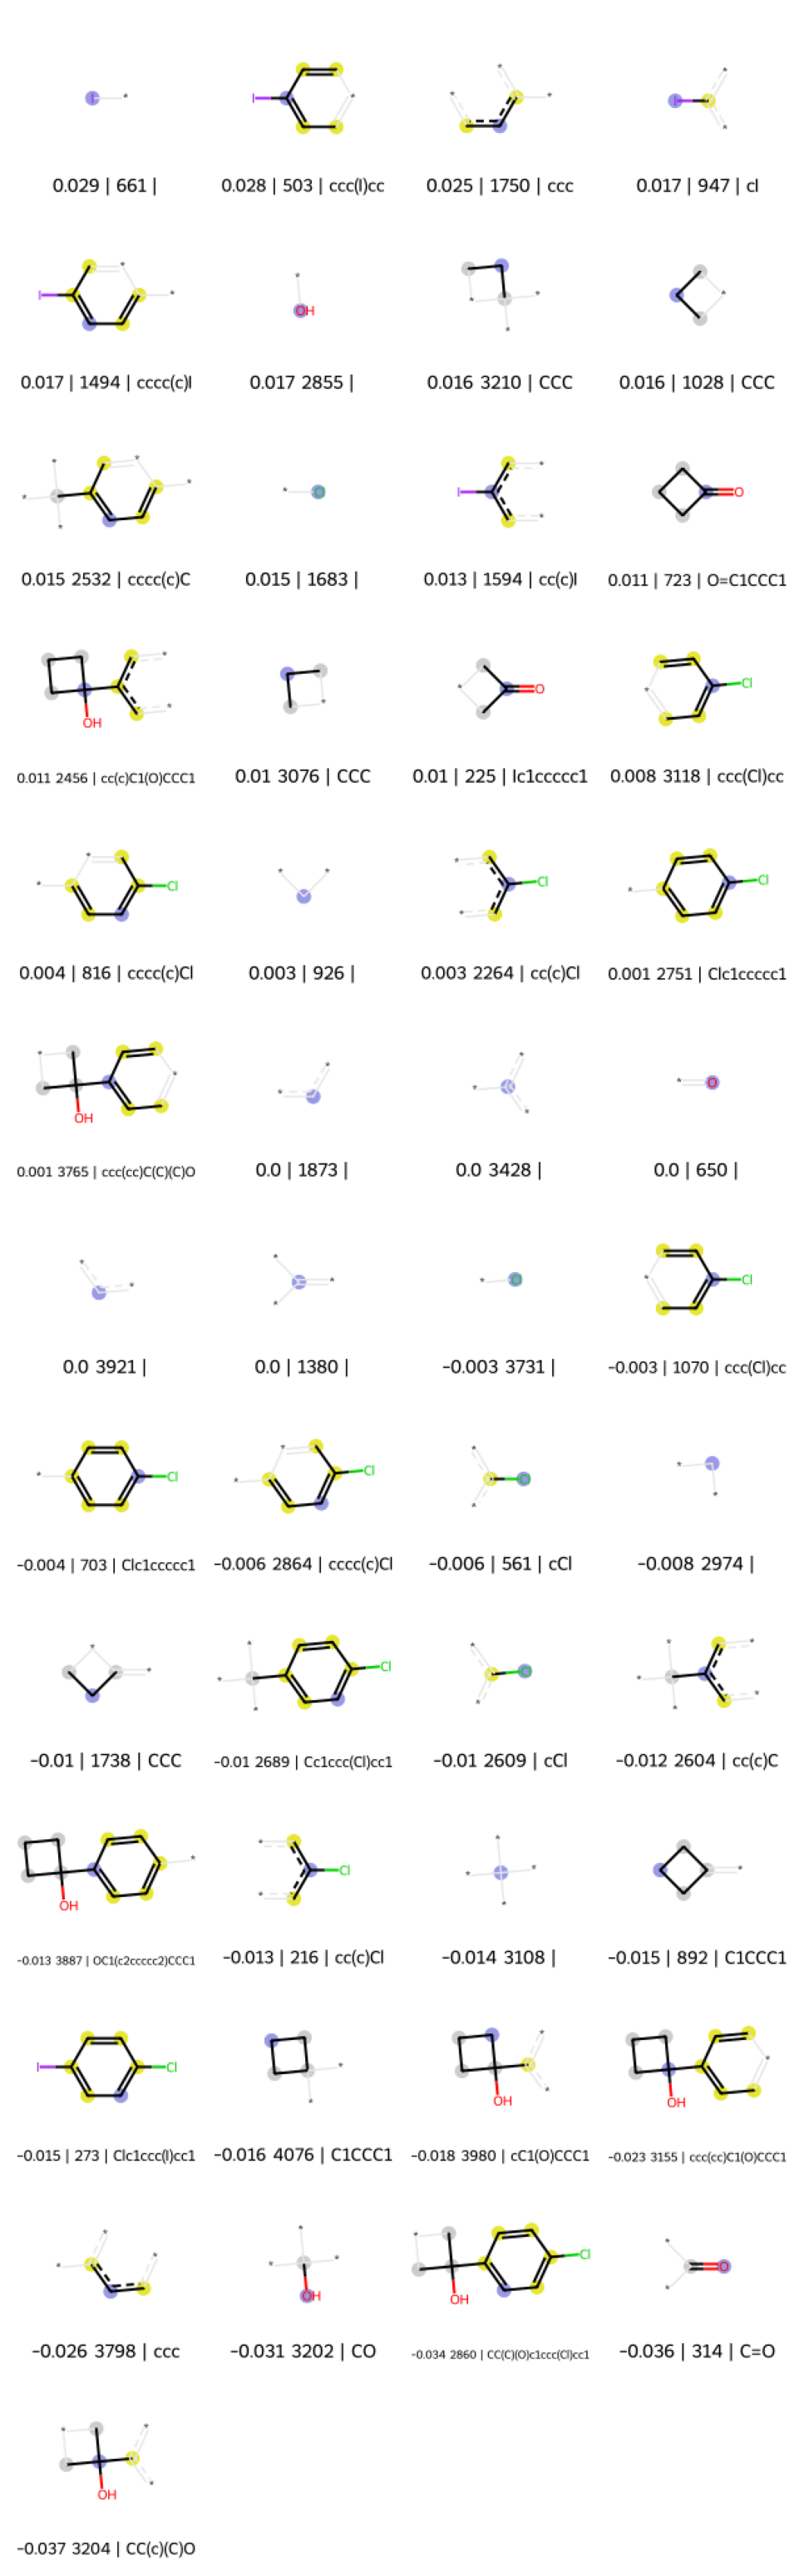

In [ ]:
def draw_lime_explanation(new_bit_list2, full_leg2):
  img = Draw.DrawMorganBits(new_bit_list2, molsPerRow=4, legends=full_leg2)
  plt.figure(figsize=(40, 40))
  plt.imshow(img)
  plt.axis('off')
  plt.show()
draw_lime_explanation(new_bit_list2, full_leg2)